# Basic Matrix Factorization with Edward

$R = UV'$ with VI

In [1]:
#configure plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,5)
from matplotlib import pyplot as plt
from IPython.display import display

In [2]:
import numpy as np
import tensorflow as tf
import edward as ed

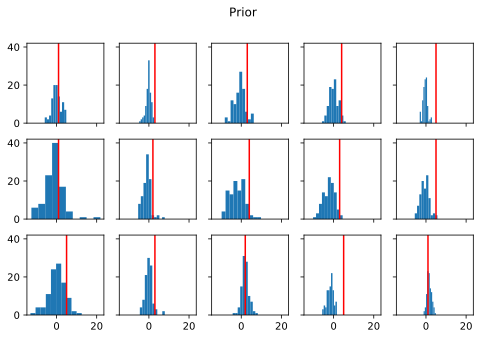

1000/1000 [100%] ██████████████████████████████ Elapsed: 7s | Loss: 72.832


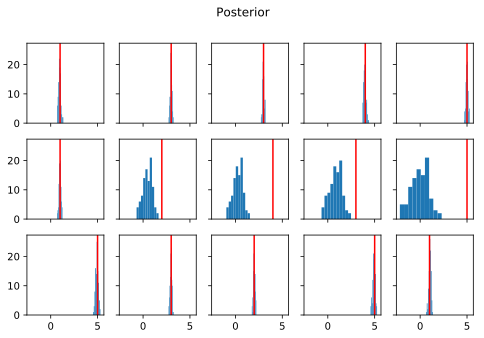

In [3]:
R_    = np.array([[1,3,3,4,5],
                  [1,2,4,3,5],
                  [5,3,2,5,1]])
mask_ = np.array([[1,1,1,1,1],
                  [1,0,0,0,0],
                  [1,1,1,1,1]])

n_users, n_items = R_.shape
latent_dim = 2

mask = tf.placeholder(tf.float32, shape=mask_.shape)

U = ed.models.Normal(loc=tf.zeros([n_users, latent_dim]), scale=tf.ones([n_users, latent_dim]), name="user_matrix")
V = ed.models.Normal(loc=tf.zeros([n_items, latent_dim]), scale=tf.ones([n_items, latent_dim]), name="item_matrix")
R = ed.models.Normal(loc=tf.matmul(U, V, transpose_b=True), scale=100 * (1-mask) + 0.1)

qU = ed.models.Normal(loc=tf.Variable(tf.random_normal([n_users, latent_dim])),
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_users, latent_dim]))))
qV = ed.models.Normal(loc=tf.Variable(tf.random_normal([n_items, latent_dim])),
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_items, latent_dim]))))

sess = ed.get_session()
tf.global_variables_initializer().run()

rhat_samples = tf.stack([tf.matmul(qU.sample(), qV.sample(), transpose_b=True) for _ in range(100)])

def plot_R(rhat_samples, title=''):
    rhats = rhat_samples.eval()
    f, axes = plt.subplots(n_users, n_items, sharex=True, sharey=True)
    for i in range(n_users):
        for j in range(n_items):
            axes[i][j].axvline(x=R_[i,j], color='r')
            axes[i][j].hist(rhats[:,i,j])
    f.suptitle(title)
    plt.show()

plot_R(rhat_samples, 'Prior')
inference = ed.KLqp({U: qU, V: qV}, data={R: R_, mask: mask_})
inference.run(n_iter=1000, n_samples=5)
plot_R(rhat_samples, 'Posterior')

# TODO

- Why are posterior uncertainty bounds so tight?
- Better priors / prior distributions?
- How to regularize this?
- How to update this when we see new data?